In [ ]:
!pip install tensorflow tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow_decision_forests.tensorflow import core_inference as tf_core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path

#Disable annoying "warnings" from tf that aren't relevant
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset as dataframe
full_df = pd.read_csv("hour.csv")
# Remove "instant" column (just an index that increments by one) and dteday column (formatted date)
stripped_full_df = full_df.drop(["instant", "dteday"], axis=1)
# Remove casual and registered column, we want to only predict cnt
stripped_full_df = stripped_full_df.drop(["casual", "registered"], axis=1)

#Shuffle
stripped_full_df = stripped_full_df.sample(frac=1, random_state=5).reset_index(drop=True)

# Split int train, validation, and test dataframes
train_percent = 0.7
val_percent = 0.2

total_count = stripped_full_df.shape[0]
train_count = int(total_count * train_percent)
val_count = int(total_count * val_percent)

train_df = stripped_full_df.iloc[:train_count,:]
val_df = stripped_full_df.iloc[train_count:(val_count+train_count),:]
test_df = stripped_full_df.iloc[(val_count+train_count):,:]

# Convert dataframes into tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="cnt", task=tf_core.Task.REGRESSION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_df, label="cnt", task=tf_core.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="cnt", task=tf_core.Task.REGRESSION)

stripped_full_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,3,0,7,1,0,3,1,1,0.70,0.6667,0.84,0.0000,11
1,3,1,8,8,0,3,1,2,0.66,0.6061,0.78,0.1940,681
2,2,1,3,21,0,5,1,1,0.38,0.3939,0.66,0.1343,220
3,4,0,11,0,0,1,1,2,0.46,0.4545,0.94,0.0000,17
4,1,1,2,6,0,4,1,2,0.30,0.3182,0.70,0.0896,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,2,6,0,4,1,1,0.16,0.1364,0.43,0.3582,39
17375,1,0,2,17,0,2,1,1,0.32,0.3030,0.22,0.2239,206
17376,3,0,8,22,0,1,1,1,0.64,0.6212,0.38,0.2985,153
17377,2,0,5,20,0,3,1,1,0.54,0.5152,0.64,0.1343,273


In [ ]:
np.amin(stripped_full_df['cnt'].to_numpy())

1

In [ ]:
import time

#Directory that the models should save to
modelSaveDir = "/content/drive/MyDrive/school/year 4/ml/regression/models"

# Define the gridsearch ranges for maximum depth and number of trees
#depth_range = (8, 16)
#trees_range = (20, 141, 10)

depth_range = (9, 10)
trees_range = (200, 281)

# depth_range = (8, 11)
# trees_range = (200, 301, 10)

#Train the model for the provided max_depth and num_trees or load a saved model if it has already been saved
def train_model(max_depth, num_trees):
  print(f'Training GBT with max_depth={max_depth} and num_trees={num_trees}:')
  saveLoc = f"{modelSaveDir}/{max_depth}_{num_trees}_model"
  if(os.path.isdir(saveLoc)):
    model = tf.keras.saving.load_model(saveLoc)
    print(f' - Loaded from file!')
  else:
    start_time = time.perf_counter()
    model = tfdf.keras.GradientBoostedTreesModel(task=tf_core.Task.REGRESSION, max_depth=max_depth, num_trees=num_trees, early_stopping="NONE", verbose=0)
    model.fit(train_ds)
    model.compile(metrics=["accuracy"])
    model.save(saveLoc)
    end_time = time.perf_counter()
    print(f' - Took {int(end_time-start_time)}s ({int((end_time-start_time)/60*100)/100}m)!')
  return model

In [ ]:
# Train Gradient Boosted Trees Model
models = [] #[[max_depth, num_trees, model], ...]
for max_depth in range(*depth_range):
  for num_trees in range(*trees_range):
    models.append([max_depth, num_trees, train_model(max_depth, num_trees)])

print(f'{len(models)} models trained!')

Training GBT with max_depth=9 and num_trees=200:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=201:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=202:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=203:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=204:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=205:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=206:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=207:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=208:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=209:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=210:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=211:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=212:
 - Loaded from file!
Training GBT with max_depth=9 and num_trees=213:
 - Loaded from file!
Training GBT with ma

In [ ]:
# Calcuate train, validation, and test errors
errors = [] #[[max_depth, num_trees, accuracy, model], ...]
errors_train = [] #[[max_depth, num_trees, accuracy, model], ...]
errors_test = [] #[[max_depth, num_trees, accuracy, model], ...]

def get_errors(depth, trees, model, ds, df, lst):
  predictions = model.predict(ds, verbose=0)
  error = 0
  for n in range(df.shape[0]):
    trueValue = df['cnt'].iloc[n]
    diff = predictions[n] - trueValue
    error += abs(diff)
  error /= df.shape[0]
  lst.append((depth, trees, error, model))

for tpl in models:
  get_errors(tpl[0], tpl[1], tpl[2], val_ds, val_df, errors)
  get_errors(tpl[0], tpl[1], tpl[2], train_ds, train_df, errors_train)
  get_errors(tpl[0], tpl[1], tpl[2], test_ds, test_df, errors_test)

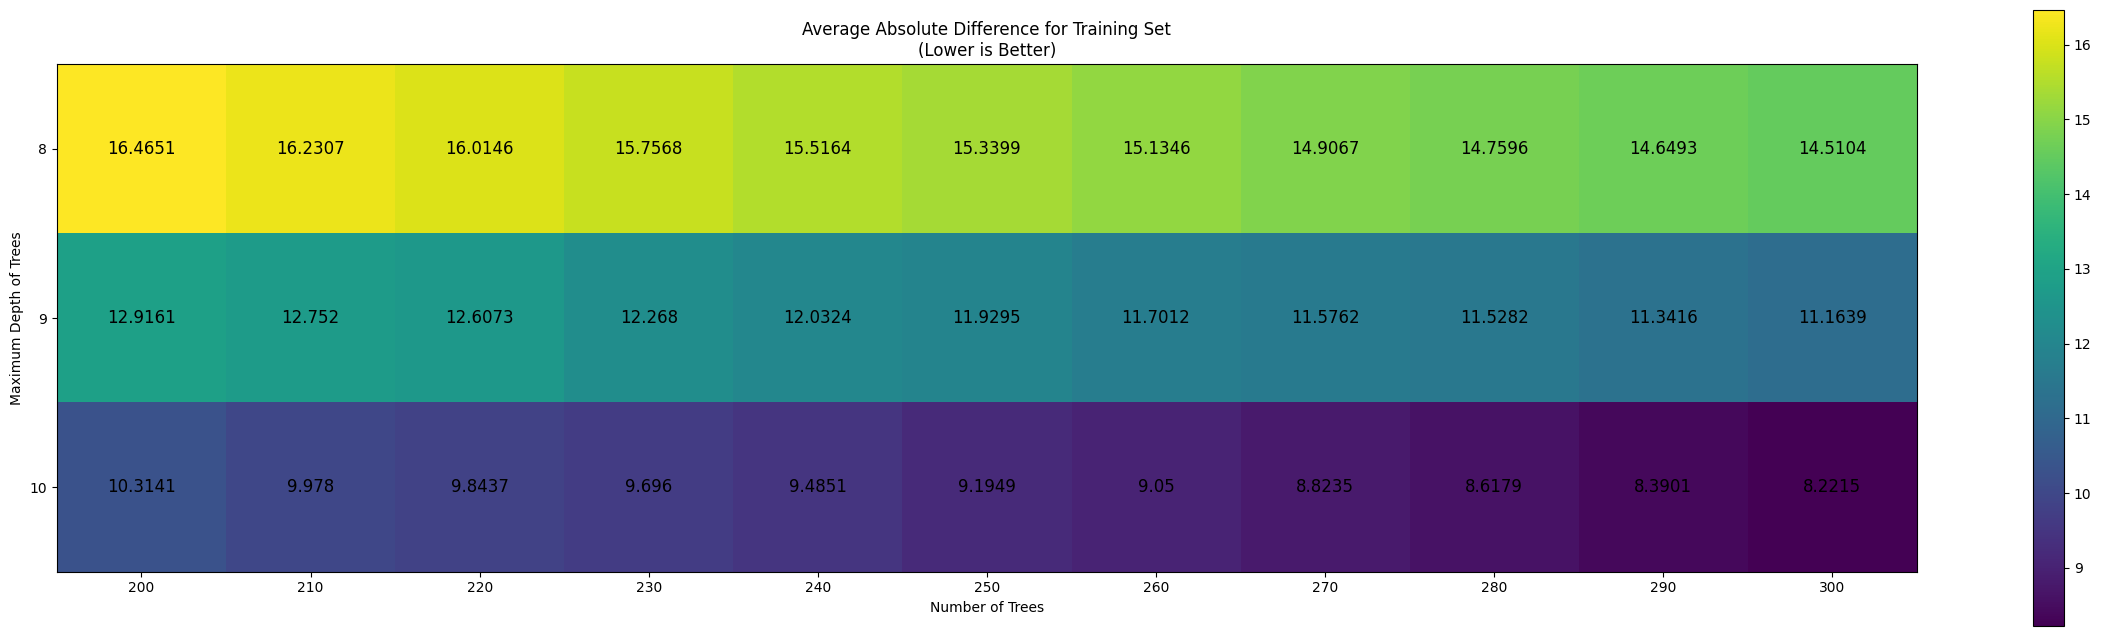

In [ ]:
# Graph gridsearch as heatmap
depths = []
trees = []
values = []

for n in range(*depth_range):
  depths.append(n)

for n in range(*trees_range):
  trees.append(n)

for depth in range(*depth_range):
  row = []
  for n_trees in range(*trees_range):
    for tpl in errors:
      if(tpl[0] == depth and tpl[1] == n_trees):
        row.append(tpl[2])
  values.append(row)

values = np.array(values)

fig, ax = plt.subplots()
im = ax.imshow(values)

ax.set_yticks(np.arange(len(depths)), labels=depths)
ax.set_xticks(np.arange(len(trees)), labels=trees)

for i in range(len(depths)):
    for j in range(len(trees)):
        val = int(values[i, j]*10000)/10000
        color = "black"
        if(val <= 24.3):
          color = "r"
        text = ax.text(j, i, val,
                       ha="center", va="center", color=color, size=12)
        
fig.set_figwidth(15)
fig.colorbar(im, ax=ax)

ax.set_title("Average Absolute Difference for Validation Set\n(Lower is Better)")
plt.xlabel("Number of Trees")
plt.ylabel("Maximum Depth of Trees")
fig.set_size_inches(30,8)

plt.show()

[200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280]


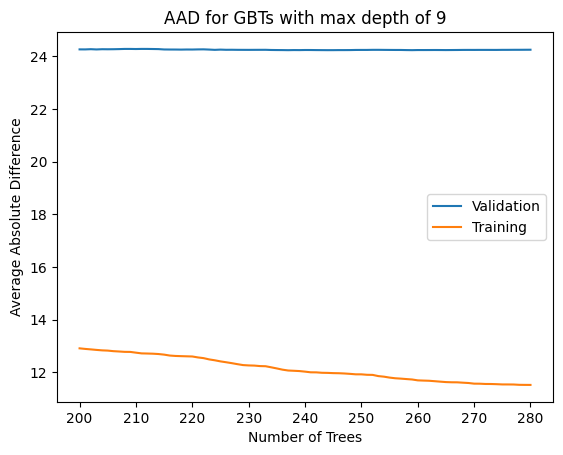

In [ ]:
# Create 2D graph for when one of max depth is set to 9
resultsValidation_N = [i[1] for i in errors]
resultsValidation_Error = [i[2] for i in errors]

resultsTraining_N = [i[1] for i in errors_train]
resultsTraining_Error = [i[2] for i in errors_train]

plt.plot(resultsValidation_N, resultsValidation_Error, label='Validation')
plt.plot(resultsTraining_N, resultsTraining_Error, label='Training')

plt.xlabel("Number of Trees")
plt.ylabel("Average Absolute Difference")
plt.title("AAD for GBTs with max depth of 9")
plt.legend(loc='best')
plt.show()

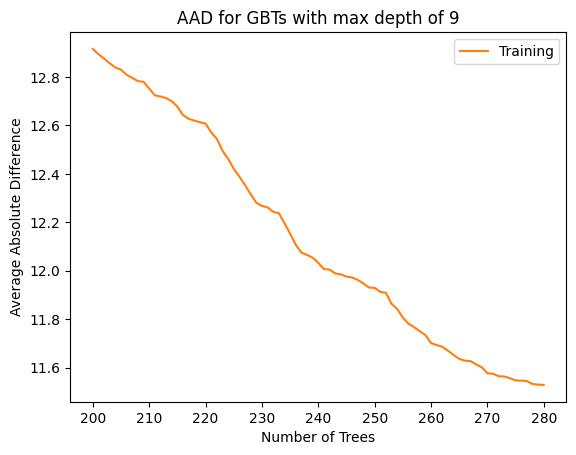

In [ ]:
plt.plot(resultsTraining_N, resultsTraining_Error, label='Training', color='#ff7f0e')

plt.xlabel("Number of Trees")
plt.ylabel("Average Absolute Difference")
plt.title("AAD for GBTs with max depth of 9")
plt.legend(loc='best')
plt.show()

In [ ]:
# Find the model with the lowest validation error
best = None
for tpl in errors:
  if best is None:
    best = tpl
  elif best[2] > tpl[2]:
    best = tpl

best

(9,
 237,
 array([24.229746], dtype=float32),
 <keras.saving.legacy.saved_model.load.GradientBoostedTreesModel at 0x7f66ba779450>)

In [ ]:
[i[2][0] for i in errors_test if i[1] == 237][0]

23.43476